In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('max_colwidth', 300)

In [2]:
# load datasets
schema = pd.read_csv('survey_results_schema.csv')
df = pd.read_csv('survey_results_public.csv')

In [3]:
df.shape

(88883, 85)

# Basic visualization (numeric data)

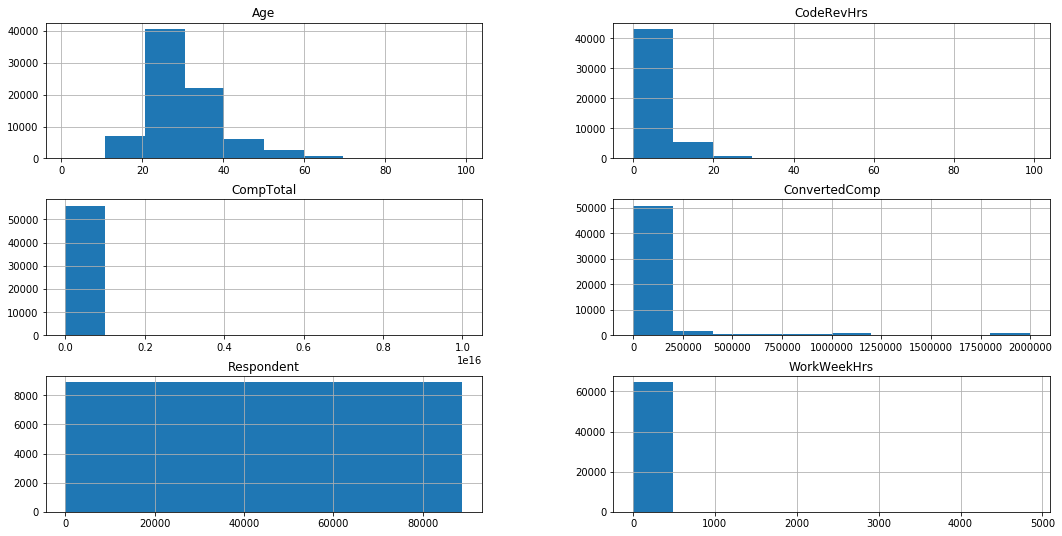

In [4]:
df.hist(figsize=(18,9));

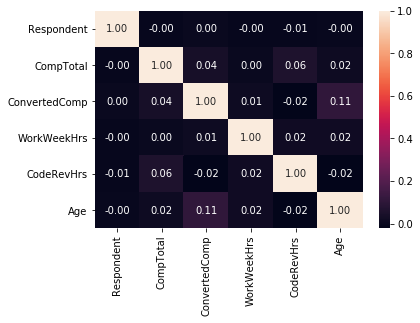

In [5]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

# Question 3

We want to predict the salary using the variables that we find significant for the salary prediction. We also want to use the limited number of variables, so we'll be very selective in the feature selection process. That's why we'll limit the number of countries to the "top 50" countries (an alternative test we'll be made with 15 countries) where "top n" means (n) countries with most rows in our data set.

# Global variables

In [7]:
# label column
label = 'ConvertedComp'

# number of countries
max_countries = 50 #alternative = 15

# Common functions

In [8]:
df[label].describe()

count    5.582300e+04
mean     1.271107e+05
std      2.841523e+05
min      0.000000e+00
25%      2.577750e+04
50%      5.728700e+04
75%      1.000000e+05
max      2.000000e+06
Name: ConvertedComp, dtype: float64

In [9]:
# Get list of unique values with count data
def unique(df, col):
    return df[col].value_counts()

# Get list of unique values with count and percentage data, including NaN
def unique_plus_nan(df, col):
    
    counts = df[col].value_counts()
    ii = counts.index.tolist()
    ii.append('NaN')
    vv = counts.values.tolist()
    vv.append(df[col].isnull().sum())
    
    r = pd.DataFrame({
        'value': ii,
        'count': vv
    }) 

    r['percentage'] = round(r['count']/len(df) * 100, 2)
    
    return r.reindex(columns=['value', 'count', 'percentage'])

# Encode feature with a single value
def encode(df, col):
    return df[col].str.get_dummies()

# check missing values
def check_missing(s):
    return {
        'count': s.isnull().sum(),
        'share': (s.isnull()).sum()/len(s)
    }

# Bar plot
def plot_bar(data, col='Salary', width=15):
    plt.xticks([1],[col])    
    data.plot(kind='bar', facecolor='peru', figsize=(width, 5))    
    plt.show()

# Plot histogram 
def plot_hist(data, col='Salary', bins=10, cumulative=False, range=(0, 2000000)):
    print(data.isin(range).shape)
    plt.figure(figsize = (15,5))
    plt.xticks([1],[col])    
    plt.hist(data[data.notnull()],
             facecolor='peru',
             edgecolor='white',
             bins=bins,
             range=range,
             cumulative=cumulative)
    plt.show()    
    
# Plot histogram with normal dist (seaborn)
def plot_dist(data, fit=norm, kde=False):
    plt.figure(figsize=(15,5))
    sns.distplot(data.dropna(), fit=fit, kde=kde)
    
# Boxplot
def plot_box(data, col='Salary', xticks_ixs=[1], xticks_lbls=['Salary'] ):
    plt.figure(figsize = (5,15))
    plt.boxplot(data)
    plt.xticks(xticks_ixs,xticks_lbls)
    plt.show()    
    
# Plot Correlation Matrix
def plot_correlation_matrix(data, size=(0,0)):
    if size == (0,0):
        if data.shape[1] < 4:
            size = (5,5)
        elif data.shape[1] < 8:
            size = (7,7)
        else:
            size = (9,9)
    corr = data.corr()
    fig, ax = plt.subplots(figsize=size)
    sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();    

# Plot Correlation Matrix with categorical column   
def plot_correlation_matrix_cat(data, col, size=(0,0)):    
    data_cm = pd.concat([data[label], encode(data, col)], axis=1)
    plot_correlation_matrix(data_cm, size)    
    
# Calculate mean salary & standard deviation for every value in a given feature
def salary_stat(df, col, ascending=True):
    return df.groupby(by=col)[label].mean().sort_values(ascending=ascending)

# Calculate missing values statistic
def missing_stat(data):   
    stat = pd.DataFrame({
            'count': data.isnull().sum(),
            'percentage': round(data.isnull().sum()/data.shape[0] * 100, 2)
        })  
    print(stat.sort_values(by='percentage', ascending=False))
    print('-------------------------------------------------')
    # count total number of rows that have at least one missing value
    missing_count = 100 - data.dropna(how='any', axis=0).shape[0]/len(data) * 100 
    print(f'Total missing rows: {round(missing_count, 2)}%')  
    print('-------------------------------------------------')


# Label: Salary (ConvertedComp)

  - description: Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks.
  - type: categorical

## Missing values

In [10]:
missing_salaries = check_missing(df[label])
print(missing_salaries)
print(f"Dataset size without missing labels: {len(df) - missing_salaries['count']}")

{'count': 33060, 'share': 0.37194964166376021}
Dataset size without missing labels: 55823


#### Remove the missing labels

If we remove the missing labels we will remove 37% of all rows. Will the remaining data  be enough to create a non-overfitted predicition model with good accuracy? 

Although we also risk that by removing the missing labels we'll remove or distort some hidden relationships between missing labels and some other predictors we opt for removing the missing labels.

We'll try to limit our features (variables) as much as possible.

In [11]:
data = df.dropna(subset=[label], axis=0)
data.shape

(55823, 85)

## Outliers

(55823,)


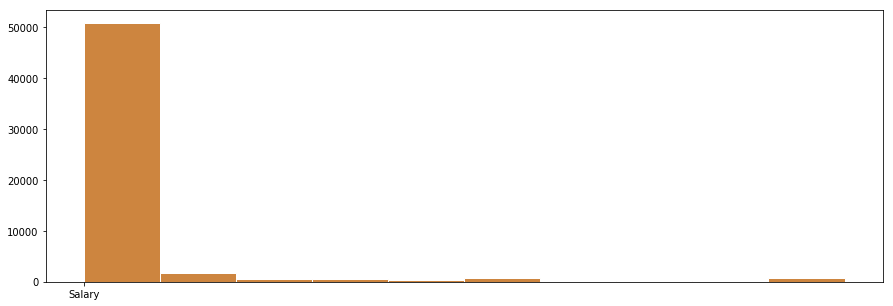

In [12]:
plot_hist(data[label], bins=10)

(55823,)


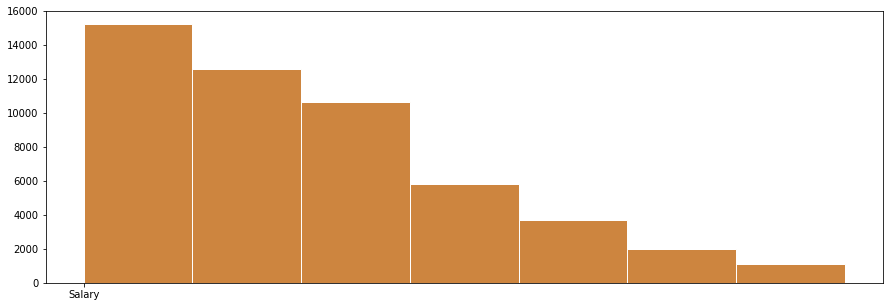

In [13]:
plot_hist(data[label], bins=7, range=(0, 200000))

(55823,)


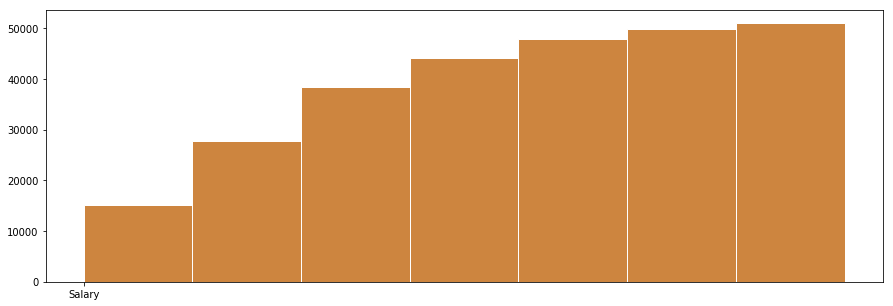

In [14]:
plot_hist(data[label], bins=7, range=(0, 200000), cumulative=True)

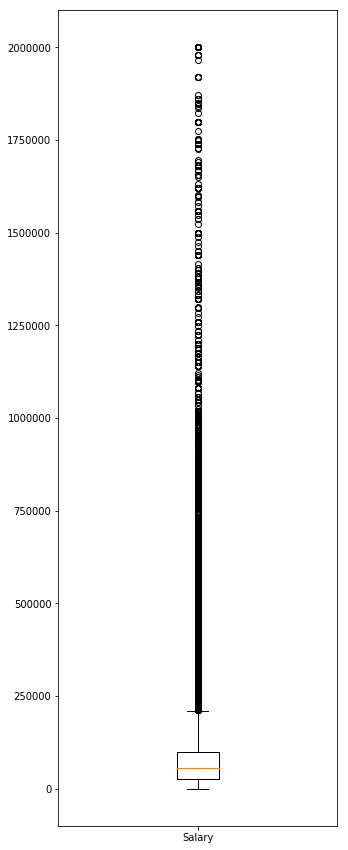

In [15]:
plot_box(data[label])

We can see the outliers from around 250.000 USD. Let's find the threshold.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


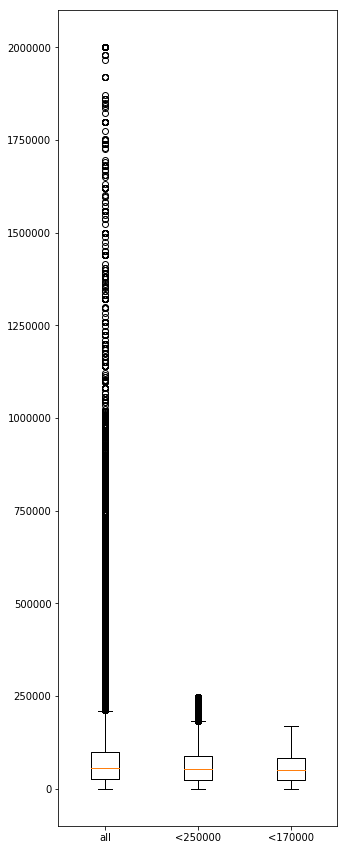

In [16]:
plot_box([data[label], data[data[label] < 250000][label], data[data[label] < 170000][label]],
        xticks_ixs=[1,2,3], xticks_lbls=['all', '<250000', '<170000'])

So it is 170.000 USD. We'll filter our data to focus on the salary range [0, 170000].

In [17]:
# Filter by MAX salary
data = data[data[label] < 170000]
data.shape

(49741, 85)

# Variable: Country

  - description: respondent's country
  - type: categorical
  - values count: 159

In [18]:
unique(data, 'Country').shape[0]

159

We'll reduce the total number of coutries (159) to top 15 countries with most data rows (top countries). Consequently, our predicition model will be limited to the top countries.

In [20]:
# Top 15 countries
countries = list(data['Country'].value_counts().head(max_countries).index)
countries

['United States',
 'India',
 'Germany',
 'United Kingdom',
 'Canada',
 'France',
 'Brazil',
 'Poland',
 'Netherlands',
 'Russian Federation',
 'Spain',
 'Australia',
 'Sweden',
 'Italy',
 'Switzerland',
 'Israel',
 'Ukraine',
 'Turkey',
 'Austria',
 'Czech Republic',
 'Mexico',
 'Belgium',
 'Pakistan',
 'Iran',
 'Romania',
 'South Africa',
 'Bulgaria',
 'Denmark',
 'Argentina',
 'Finland',
 'Norway',
 'Portugal',
 'Hungary',
 'New Zealand',
 'Greece',
 'Ireland',
 'Bangladesh',
 'Japan',
 'China',
 'Serbia',
 'Indonesia',
 'Colombia',
 'Slovenia',
 'Nigeria',
 'Sri Lanka',
 'Croatia',
 'Lithuania',
 'Philippines',
 'Egypt',
 'Slovakia']

In [21]:
# Check the shape before and after the reduction
print(f'all countries: {data.shape[0]}')
print(f'top countries: {data[data["Country"].isin(countries)].shape[0]}')

all countries: 49741
top countries: 46394


In [22]:
# Reduce data to top countries
data = data[data['Country'].isin(countries)]
data.shape

(46394, 85)

In [23]:
# Calc salary mean for every country from the list 
salary_stat(data, col='Country', ascending=False)

Country
United States         97125.556614
Israel                84498.902703
Switzerland           84221.099650
Denmark               81599.030457
Norway                78903.495775
Australia             76388.450281
Ireland               74360.462745
Canada                68298.456681
United Kingdom        65754.850259
New Zealand           65203.646688
Germany               60574.212113
Netherlands           59174.474592
Sweden                58281.013793
Finland               56308.690860
Belgium               54003.635135
Austria               53819.341667
Japan                 52792.661088
France                50125.806680
South Africa          43067.270471
Spain                 40856.304878
Slovenia              39494.707071
Czech Republic        38342.552301
Lithuania             38104.312500
Italy                 37810.097735
Poland                35476.899540
Romania               34607.292079
Slovakia              33950.657534
Bulgaria              32751.421717
China       

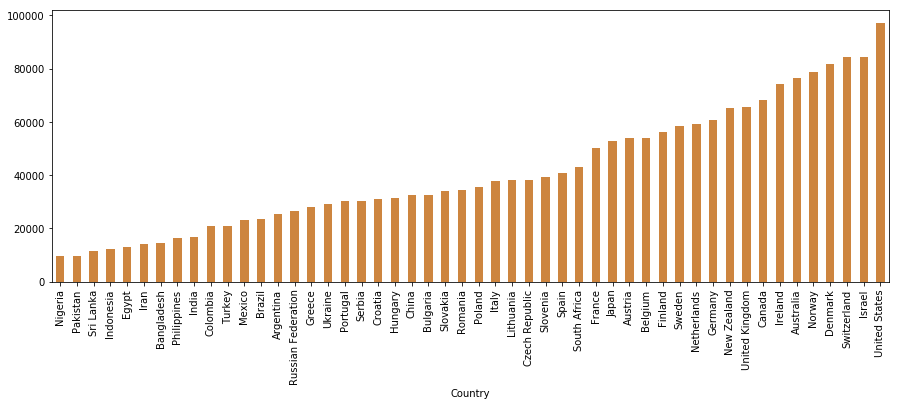

In [24]:
plot_bar(salary_stat(data, 'Country'))

We can see that the salary definetely depends on the country. You'll very likely not earn the same money as the developer if you work in India or if you work in the United States.

Let's check the salary label after making the data reduction:

(46394,)


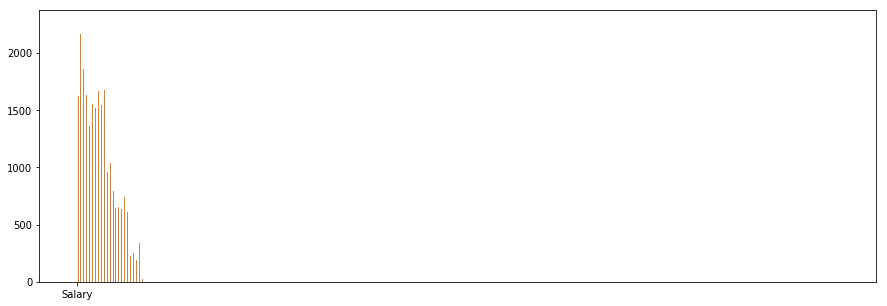

In [25]:
plot_hist(data[label], bins=500)

Let's try with seaborn:

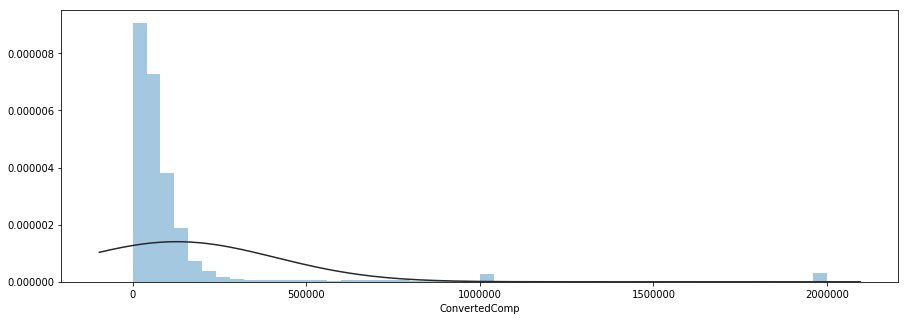

In [26]:
# Before the reduction:
plot_dist(df[label])

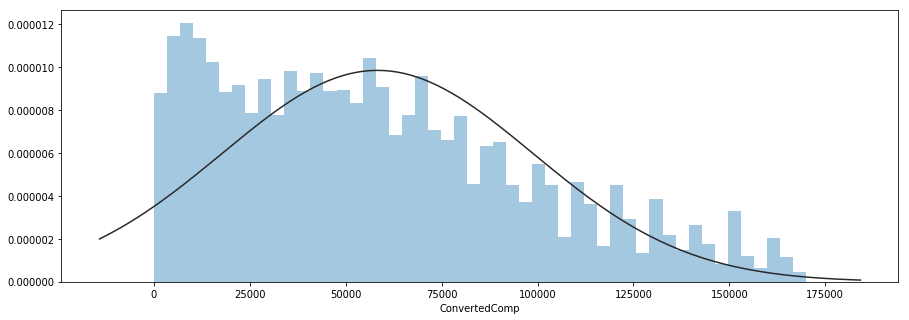

In [27]:
# After the reduction:
plot_dist(data[label])

We have cut the outliers and substantially narrowed the interval between min and max salary. It can be seen that the distribution of the salaries above 25.000 USD follows pretty well the normal distribution.

# Variable: Age (QUESTIONED)

  - description: respondent's age
  - type: numerical
  - values count: 78

In [28]:
unique(data, 'Age').shape[0]

89

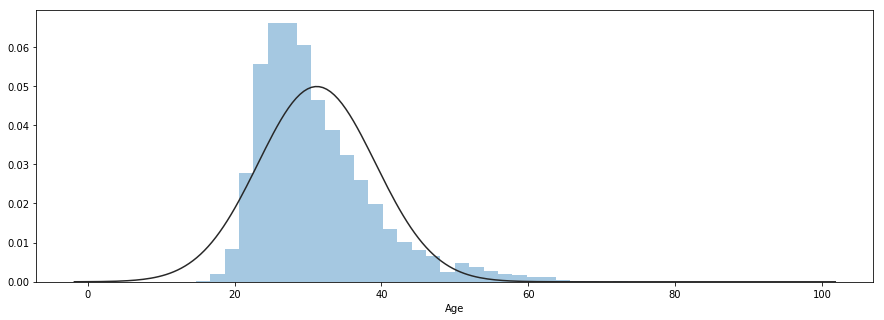

In [29]:
plot_dist(data.Age)

In [30]:
print(f"Average age: {round(data['Age'].mean())}")

Average age: 31


In [31]:
# Categorize the age 
def get_agecat(age):
    if age < 26:
        return 'young'
    elif age < 36:
        return 'average'
    else:
        return 'veteran'
    
data['AgeCat'] = data.Age.apply(get_agecat)    

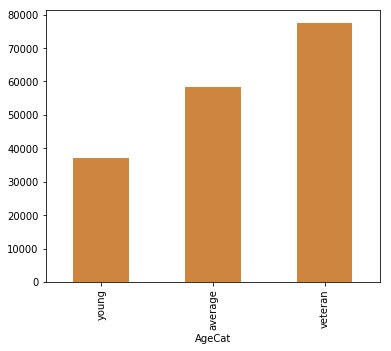

In [32]:
plot_bar(salary_stat(data, 'AgeCat'), width=6)

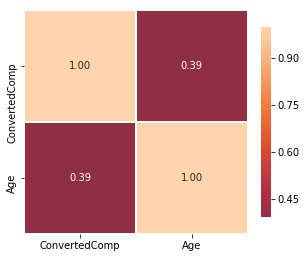

In [33]:
plot_correlation_matrix(data[[label, 'Age']])

It's evident that the age has impact on the salary. 

# Variable: YearsCodePro

  - description: years of professional coding
  - type: numeric with 2 string values
  - values count: 51

In [34]:
unique(data, 'YearsCodePro').shape[0]

51

In [36]:
# Handle 2 string values converting them to numeric
def get_yearscodepro_num(val):
    if val == 'Less than 1 year':
        return 0
    elif val == 'More than 50 years':
        return 51
    else:
        return int(val)
    
# Categorize the years of professional programming 
def get_yearscodepro_cat(years):
    years2 = get_yearscodepro_num(years)
    if years2 < 5:
        return 'years-young'
    elif years2 < 12:
        return 'years-average'
    else:
        return 'years-veteran'
    
data['YearsCodeProCat'] = data.YearsCodePro.dropna().apply(get_yearscodepro_cat) 

In [37]:
data.YearsCodePro.dropna().apply(get_yearscodepro_num).mean()

7.75639806328895

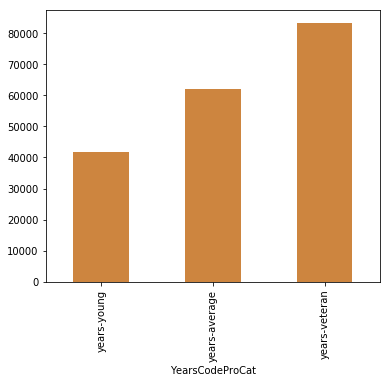

In [38]:
plot_bar(salary_stat(data, 'YearsCodeProCat'), width=6)

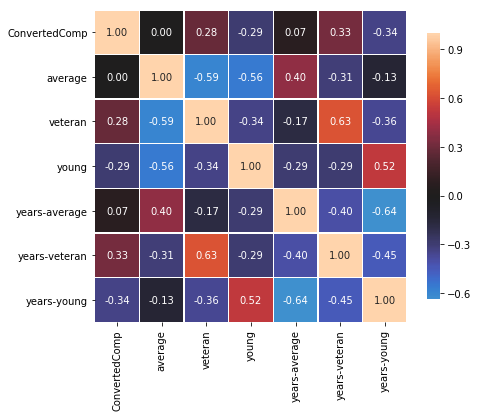

In [39]:
data_cm = pd.concat([data[label], encode(data, 'AgeCat'), encode(data, 'YearsCodeProCat')], axis=1)
plot_correlation_matrix(data_cm)

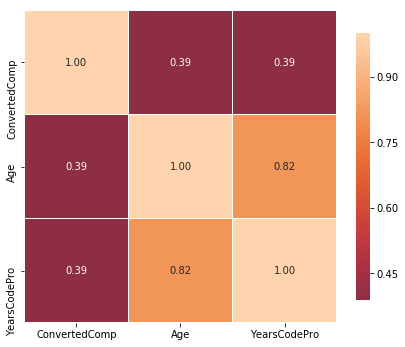

In [40]:
# Let us check the correlation matrix between the Age and YearsCodePro for the numeric values as well.
data_cm = pd.concat([
    data[label],
    data.Age, 
    data.YearsCodePro.dropna().apply(get_yearscodepro_num)], axis=1)
plot_correlation_matrix(data_cm, size=(7,7))

The correlation matrix shows that the years of professional programming are in correspondence with the age of the programmer in terms of the salary: young programmers have a short career, average-aged have an average duration of the career and the veteran programmers have a long career. It looks that the both variables, Age and YearsCodePro, are interdependent. This becomes even more clear if we check the correlation coefficients of the similar pairs like (young, years-young), (average, years-average), and (veteran, years-veteran) - the highest positive correlation coefficients are found here! 

For that reason we conclude that there is no need to keep both variables. We must decide which variable we'll be kept.

Let's check the missing values:

In [41]:
pd.DataFrame({
    'count': data[['Age', 'YearsCodePro']].isnull().sum(),
    'share': round(data[['Age', 'YearsCodePro']].isnull().sum()/len(data) * 100, 2)
})

,count,share
Age,1847,3.98
YearsCodePro,130,0.28


Due to the significant difference in missing values it has sense to rule out the Age column and to keep YearsCodePro. 

# Variable: Gender (INSIGNIFICANT)

  - description: respondent's gender
  - type: categorical
  - values count: 7

In [42]:
unique(data, 'Gender')

Man                                                            41884
Woman                                                           3230
Non-binary, genderqueer, or gender non-conforming                283
Man;Non-binary, genderqueer, or gender non-conforming             99
Woman;Non-binary, genderqueer, or gender non-conforming           94
Woman;Man                                                         36
Woman;Man;Non-binary, genderqueer, or gender non-conforming       18
Name: Gender, dtype: int64

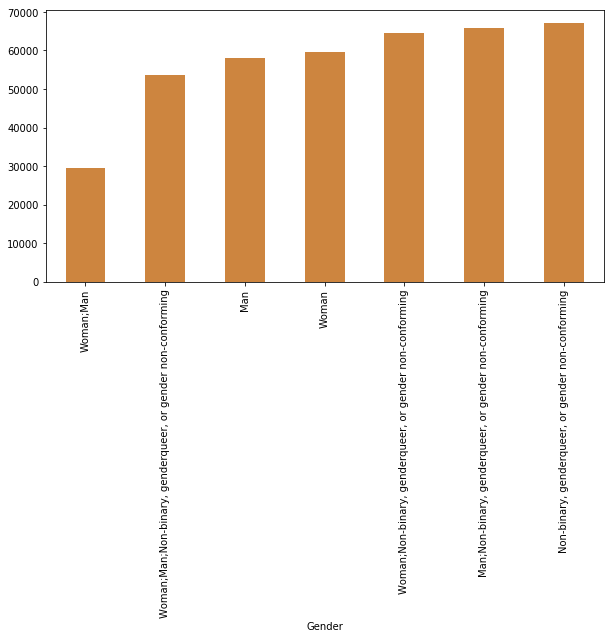

In [43]:
plot_bar(salary_stat(data, 'Gender'), width=10)

In [44]:
print(f"Percentage of respondents declared as 'Man' or 'Woman': \
{data['Gender'].isin(['Man', 'Woman']).sum()/len(data) * 100}")

Percentage of respondents declared as 'Man' or 'Woman': 97.24102254601888


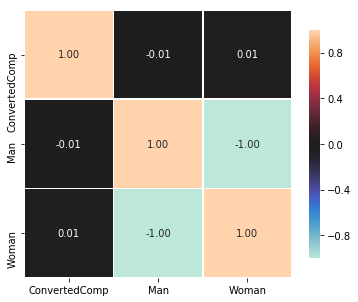

In [45]:
plot_correlation_matrix_cat(data[data['Gender'].isin(['Man', 'Woman'])], 'Gender', size=(6,6))

If we evaluate only the gender categories 'Man' and 'Woman' (97%), then we can't see significant difference between the sexes relating to their salary. So we'll discard the Gender feature as insignificant. 

# Variable: Student

  - description: is the respondent a student?
  - type: categorical
  - values count: 3

In [46]:
unique(data, 'Student')

No                39054
Yes, full-time     4263
Yes, part-time     2796
Name: Student, dtype: int64

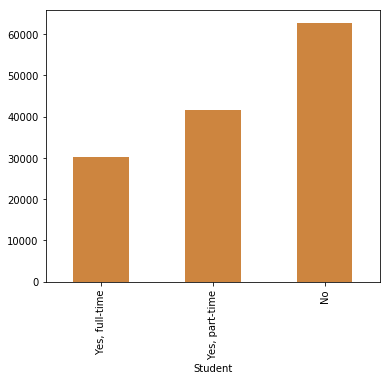

In [47]:
plot_bar(salary_stat(data, 'Student'), width=6)

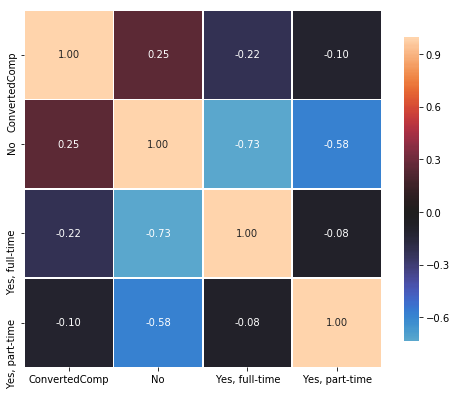

In [48]:
plot_correlation_matrix_cat(data, 'Student', size=(8,8))

Without any doubt, it matters if you study or not.

# Variable: Employment

  - description: respondent's current employment status
  - type: categorical
  - values count: 3

In [49]:
unique(data, 'Employment')

Employed full-time                                      40856
Independent contractor, freelancer, or self-employed     3573
Employed part-time                                       1851
Name: Employment, dtype: int64

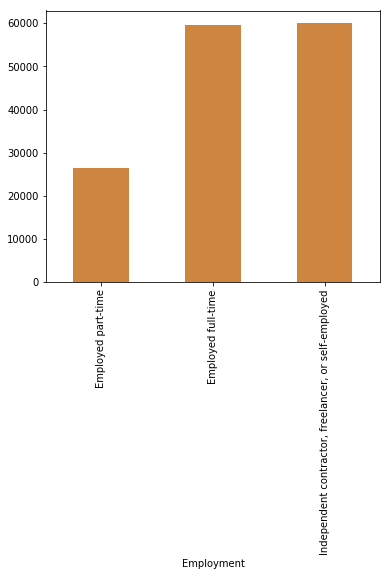

In [50]:
plot_bar(salary_stat(data, 'Employment'), width=6)

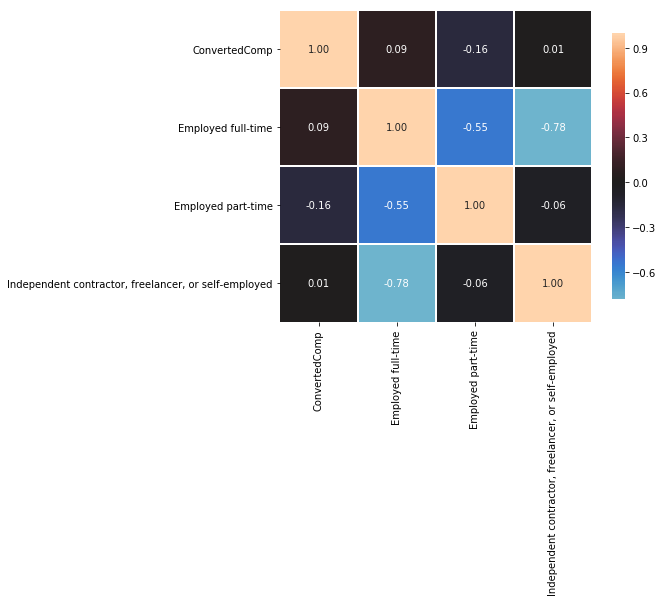

In [51]:
plot_correlation_matrix_cat(data, 'Employment')

Working part-time evidently affects the salary.

# Variable: EdLevel (INSIGNIFICANT)

  - description: respondent's formal education level
  - type: categorical
  - values count: 9

In [52]:
unique(data, 'EdLevel')

Bachelor’s degree (BA, BS, B.Eng., etc.)                                              22260
Master’s degree (MA, MS, M.Eng., MBA, etc.)                                           11635
Some college/university study without earning a degree                                 5443
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     2483
Associate degree                                                                       1582
Other doctoral degree (Ph.D, Ed.D., etc.)                                              1327
Professional degree (JD, MD, etc.)                                                      574
Primary/elementary school                                                               213
I never completed any formal education                                                  166
Name: EdLevel, dtype: int64

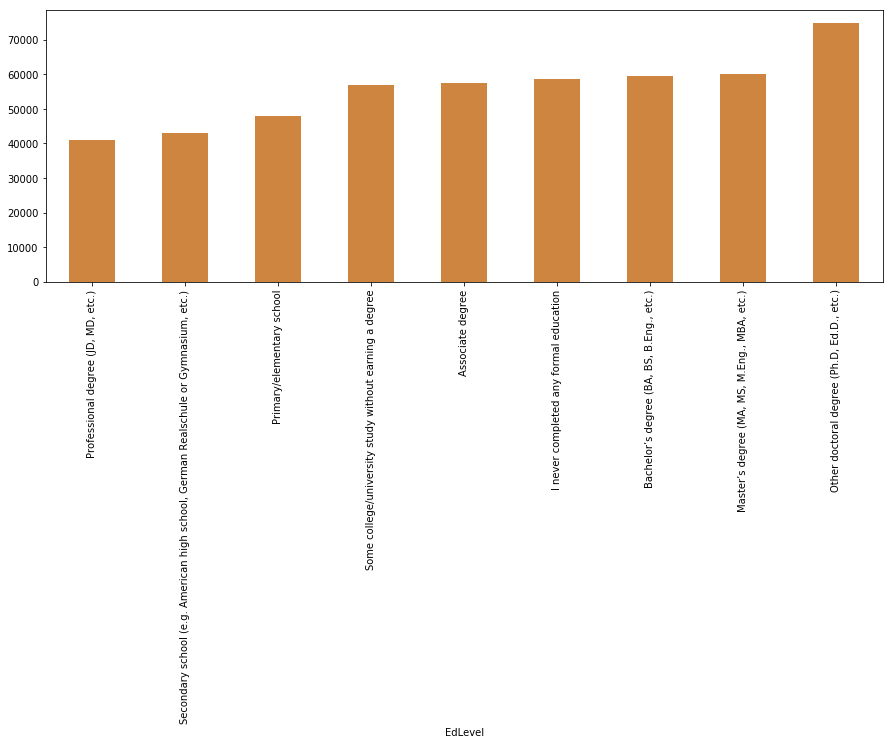

In [53]:
plot_bar(salary_stat(data, 'EdLevel'), width=15)

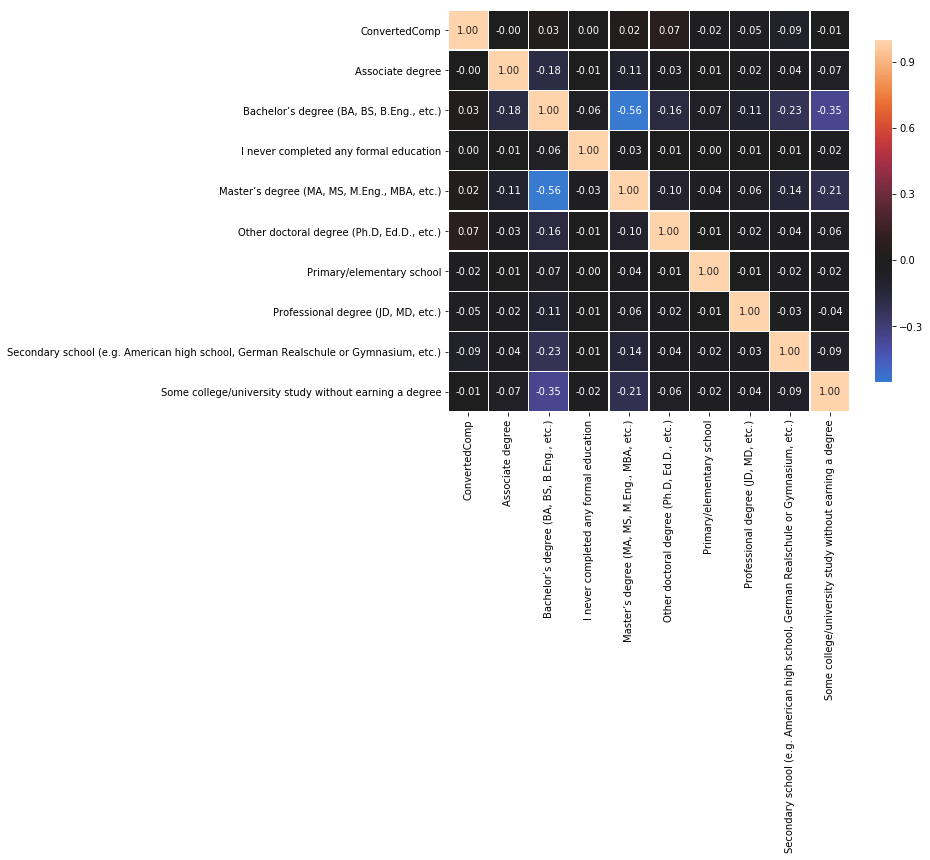

In [54]:
plot_correlation_matrix_cat(data, 'EdLevel')

In the both graphs we see that in some cases, higher the education level greater the salary. Yet the correlation matrix hasn't quite confirmed this difference, the max coefficient is -10% for the secondary school. Since we are very picky with the features we'll rule out the EdLevel feature as insignificant.

# Variable: WorkWeekHrs (INSIGNIFICANT)

  - description: working hours per week
  - type: numerical
  - values count: 165

In [55]:
unique(data, 'WorkWeekHrs').shape[0]

180

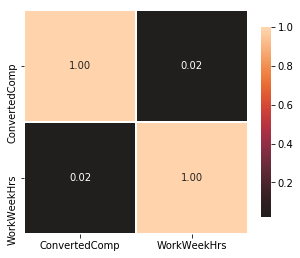

In [56]:
plot_correlation_matrix(data[[label, 'WorkWeekHrs']])

The correlation coefficient hasn't changed significaly if we compare this correlation matrix with the one of the original data.

# Variable: OrgSize

  - description: size of the company where the respondent is employed
  - type: categorical
  - values count: 9

In [57]:
unique(data, 'OrgSize')

20 to 99 employees                                    10233
100 to 499 employees                                   8595
10,000 or more employees                               6165
1,000 to 4,999 employees                               4858
10 to 19 employees                                     4427
2-9 employees                                          4424
500 to 999 employees                                   3059
5,000 to 9,999 employees                               1969
Just me - I am a freelancer, sole proprietor, etc.     1822
Name: OrgSize, dtype: int64

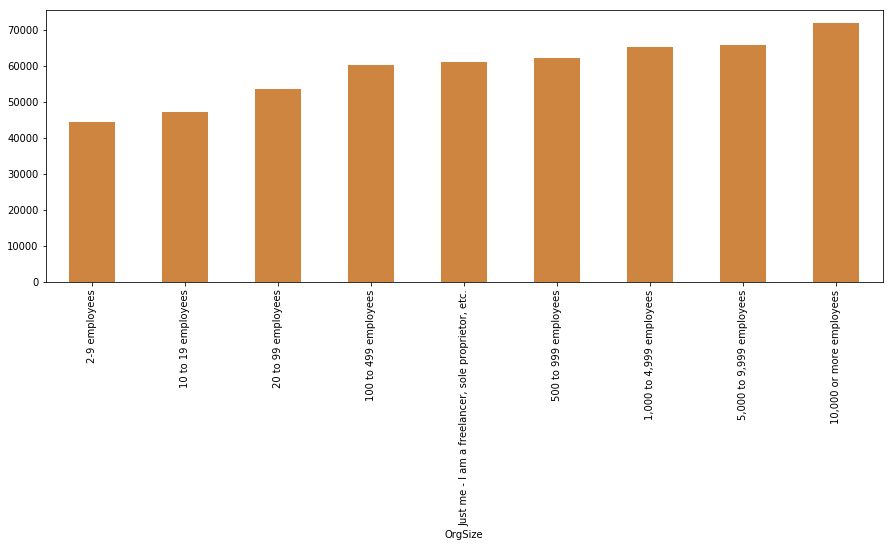

In [58]:
plot_bar(salary_stat(data, 'OrgSize'))

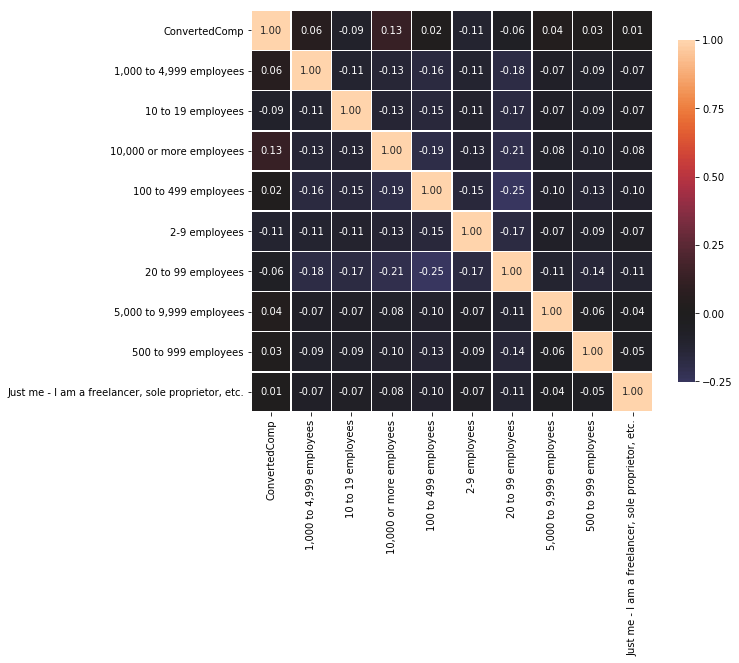

In [59]:
plot_correlation_matrix_cat(data, 'OrgSize')

The size of the company is in strict linear correlation with the salary (with the exception of the freelancer): bigger the company bigger the salary. 

# Variable: WorkRemote

  - description: How often do you work remotely?
  - type: categorical
  - values count: 7

In [60]:
unique(data, 'WorkRemote')

Less than once per month / Never                           20411
A few days each month                                      11750
All or almost all the time (I'm full-time remote)           5220
Less than half the time, but at least one day each week     4269
It's complicated                                            2000
More than half, but not all, the time                       1438
About half the time                                         1185
Name: WorkRemote, dtype: int64

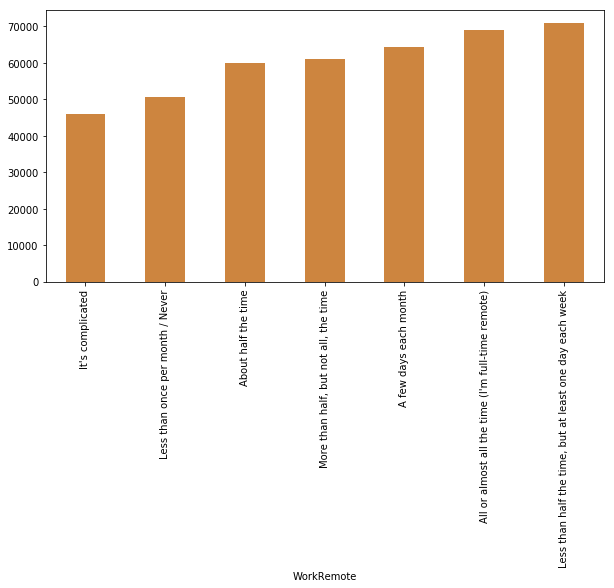

In [61]:
plot_bar(salary_stat(data, 'WorkRemote'), width=10)

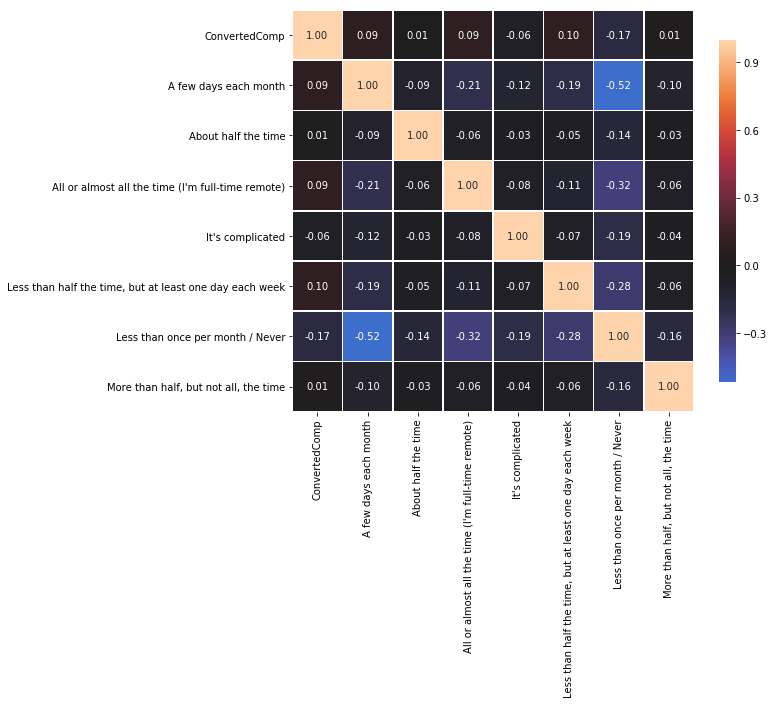

In [62]:
plot_correlation_matrix_cat(data, 'WorkRemote')   

Although not perfectly linearly, the remote work is in a certain relationship with the salary: the negative correlation of -19% is found in cases when the respondents work remotely less than once per month or never, and the positive correlation of 12% in cases when the respondents work full-time or almost all the time remotely. 

# Variable: ImpSyn

  - description: level of own compentence given by the respondent  
  - type: categorical
  - values count: 5

In [63]:
unique(data, 'ImpSyn')

A little above average    21487
Average                   10874
Far above average          9603
A little below average     3414
Far below average           914
Name: ImpSyn, dtype: int64

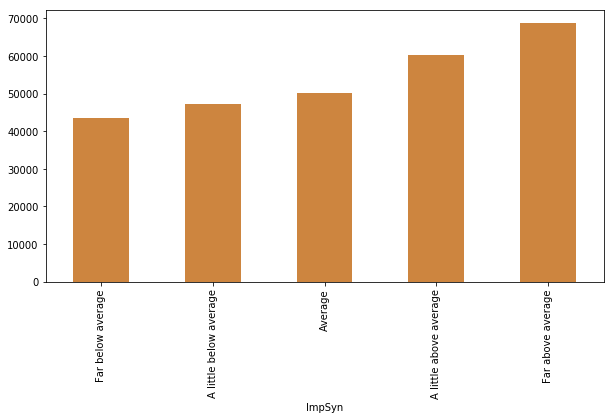

In [64]:
plot_bar(salary_stat(data, 'ImpSyn'), width=10)

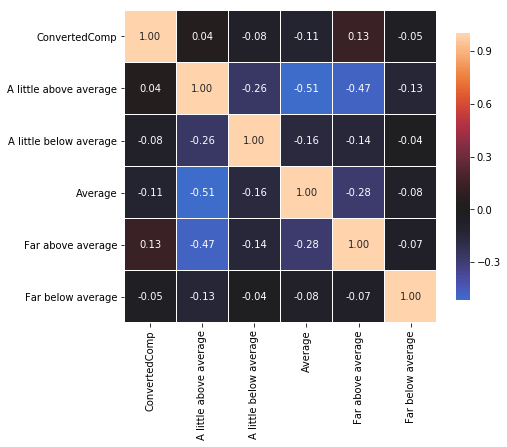

In [65]:
plot_correlation_matrix_cat(data, 'ImpSyn')  

We find very linear correlation between the own competence level and the salary: less compentent, lower the salary; more competent, higher the salary. 

# Variable: FizzBuzz

  - description: Have you ever been asked to solve FizzBuzz in an interview?
  - type: categorical
  - values count: 2

In [66]:
unique(data, 'FizzBuzz')

No     39220
Yes     6796
Name: FizzBuzz, dtype: int64

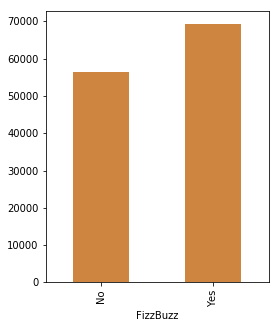

In [67]:
plot_bar(salary_stat(data, 'FizzBuzz'), width=4)

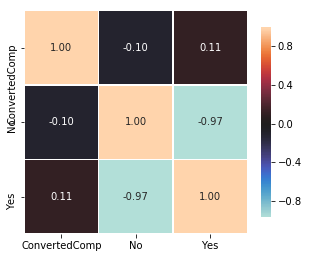

In [68]:
plot_correlation_matrix_cat(data, 'FizzBuzz')  

The FizzBuzz test is "a very simple programming task, used in software developer job interviews, to determine whether the job candidate can actually write code." (https://www.tomdalling.com/blog/software-design/fizzbuzz-in-too-much-detail/). It looks that if the respondent does the FizzBuzz test in the job interview it will have a greater salary than the respondent that doesn't do it.

# Columns Selection Summary

We have selected the following 8 columns (variables):
- **Country** (limited to top 15 countries) [Basic Info]
- **Employment** [Basic Info]    
- **YearsCodePro** [Education, Work, Career]
- **Student** [Education, Work, Career]
- **OrgSize** [Education, Work, Career]
- **WorkRemote** [Education, Work, Career]
- **ImpSyn** [Education, Work, Career]
- **FizzBuzz** [Education, Work, Career]

In [69]:
# Let us focus on target data that contain the label column and all variables
cols = [label, 'Country', 'Employment', 'YearsCodePro', 'Student', 'OrgSize', 'WorkRemote', 'ImpSyn', 'FizzBuzz']
target = data[cols].copy()
target.shape

(46394, 9)

# Data Preparation

### Missing Values

In [70]:
missing_stat(target)

               count  percentage
OrgSize          842        1.81
FizzBuzz         378        0.81
Student          281        0.61
YearsCodePro     130        0.28
WorkRemote       121        0.26
Employment       114        0.25
ImpSyn           102        0.22
ConvertedComp      0        0.00
Country            0        0.00
-------------------------------------------------
Total missing rows: 3.62%
-------------------------------------------------


The percentage of total missing rows is not high. Let us check if the missing values of the top three missing features (OrgSize, FizzBuzz, Student) are in any correlation to the salary.

In [81]:
# Compare salary mean for non-nan and nan values for a given 2 columns
def plot_nan_compare(df, col1, col2):
    stat1 = pd.DataFrame({ 'non-nan': salary_stat(df, col1)})
    stat2 = pd.DataFrame({ 'nan': salary_stat(df[df[col2].isnull()], col1)})
    stat = pd.concat([stat1, stat2], axis=1)
    # plot
    stat.plot(kind='barh', figsize=(5, 15))
    plt.xticks();
    
# Replace NaN by 'N/A' value
def nan_to_na(val):
    if pd.isnull(val):
        return 'N/A'
    else:
        return val
    

In [72]:
# dataset for NaN tests
test = target.copy()

#### OrgSize

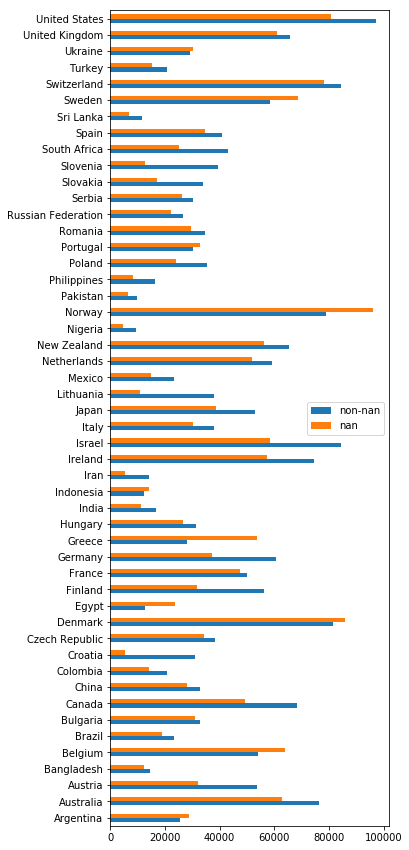

In [82]:
# Let us compare the impact of OrgSize NaN to the salary distribution over the countries 
plot_nan_compare(target, 'Country', 'OrgSize')

It look like that the missing OrgSize value lowers the salary. Now let's check the correlation matrix - we'll replace NaN by "N/A" value.

In [83]:
test.OrgSize = test.OrgSize.apply(nan_to_na)
test.OrgSize.isnull().sum()

0

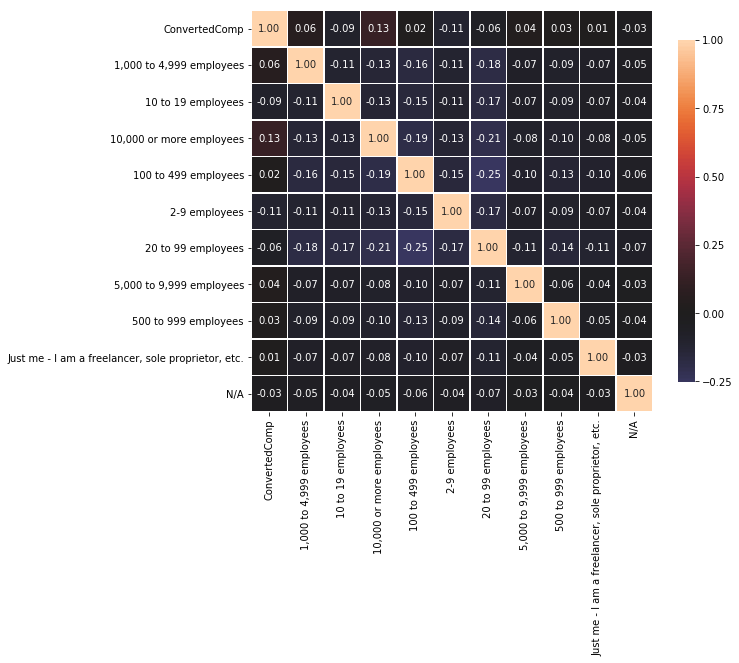

In [84]:
plot_correlation_matrix_cat(test, 'OrgSize')  

There is a slightly negative correlation between the OrgSize's N/A (NaN) values and the salary.

#### FizzBuzz

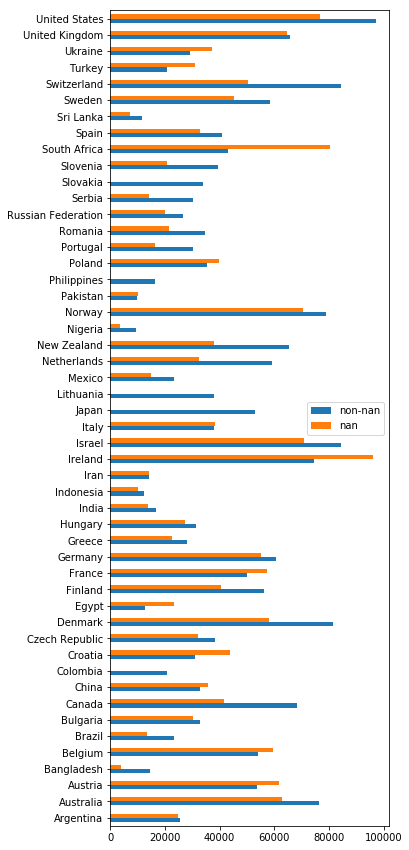

In [85]:
plot_nan_compare(target, 'Country', 'FizzBuzz')

0


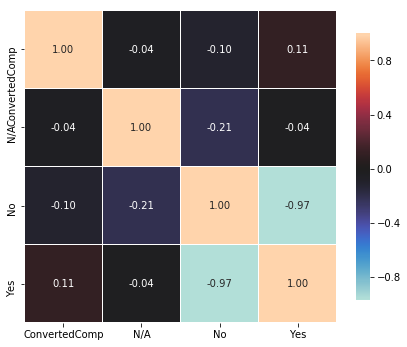

In [86]:
test.FizzBuzz = test.FizzBuzz.apply(nan_to_na)
print(test.FizzBuzz.isnull().sum())
plot_correlation_matrix_cat(test, 'FizzBuzz') 

The same as for the OrgSize holds for the FizzBuzz feature: the missing values are in slightly negative correlation with the salary.

#### Student

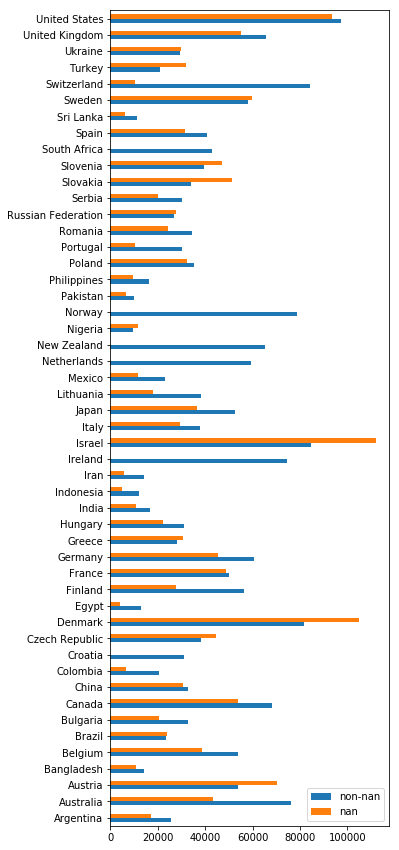

In [87]:
plot_nan_compare(target, 'Country', 'Student')

0


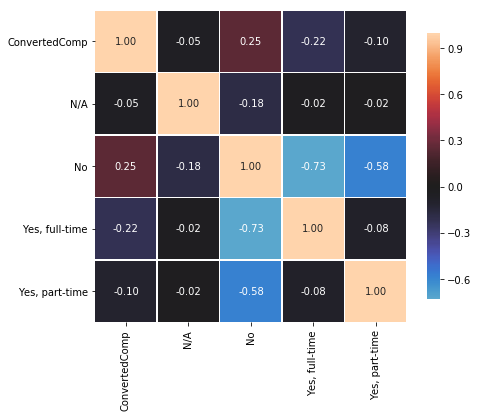

In [88]:
test.Student = test.Student.apply(nan_to_na)
print(test.Student.isnull().sum())
plot_correlation_matrix_cat(test, 'Student') 

Although the missing values for all three columns demonstrate certain grade of correlation with the salary, the magnitudes of coefficients do not convince us to keep this missing values (as 'N/A'). So we'll remove them. 

#### Handle Missing Values

In [89]:
# Drop rows with at least one missing value
target = target.dropna(how='any', axis=0)
target.shape

(44715, 9)

In [90]:
missing_stat(target)

               count  percentage
ConvertedComp      0         0.0
Country            0         0.0
Employment         0         0.0
YearsCodePro       0         0.0
Student            0         0.0
OrgSize            0         0.0
WorkRemote         0         0.0
ImpSyn             0         0.0
FizzBuzz           0         0.0
-------------------------------------------------
Total missing rows: 0.0%
-------------------------------------------------


### Data Adjustments

We'll check the values of every feature and make adjustments (duplicate search, apply shorter names...) if necessary.

#### Country

In [91]:
unique_plus_nan(target, 'Country')

,value,count,percentage
0,United States,11257,25.17
1,India,3671,8.21
2,Germany,3373,7.54
3,United Kingdom,3196,7.15
4,Canada,1973,4.41
5,France,1524,3.41
6,Brazil,1322,2.96
7,Poland,1254,2.80
8,Netherlands,1086,2.43
9,Russian Federation,1054,2.36


Country is OK, no need to do anything.

#### Employment

In [92]:
unique_plus_nan(target, 'Employment')

,value,count,percentage
0,Employed full-time,39554,88.46
1,"Independent contractor, freelancer, or self-employed",3404,7.61
2,Employed part-time,1757,3.93
3,NaN,0,0.00


Let's shorten the descriptions.

In [93]:
# Shortenizer
def get_employment(val):
    if val in ['Employed part-time']:
        return 'part-time'
    elif val in ['Independent contractor, freelancer, or self-employed']:
        return 'freelancer'
    elif val in ['Employed full-time']:
        return 'full-time'
    else:
        return 'not found'
    
target.Employment = target.Employment.apply(get_employment)
unique(target, 'Employment')

full-time     39554
freelancer     3404
part-time      1757
Name: Employment, dtype: int64

#### Student

In [94]:
unique_plus_nan(target, 'Student')

,value,count,percentage
0,No,37995,84.97
1,"Yes, full-time",4001,8.95
2,"Yes, part-time",2719,6.08
3,NaN,0,0.00


Since the Student feature is based on Yes/No question, we'll convert 'Yes, full-time' and 'Yes, part-time' into 'Yes'. the information 'full-time', 'part-time' is not important.

In [95]:
# Converter
def get_student(val):
    if val in ['Yes, full-time', 'Yes, part-time']:
        return 'Yes'
    elif val in ['No', 'N/A']:
        return val
    else:
        return 'not found'
    
target.Student = target.Student.apply(get_student)
unique(target, 'Student')

No     37995
Yes     6720
Name: Student, dtype: int64

#### OrgSize

In [96]:
unique_plus_nan(target, 'OrgSize')

,value,count,percentage
0,20 to 99 employees,10052,22.48
1,100 to 499 employees,8457,18.91
2,"10,000 or more employees",6072,13.58
3,"1,000 to 4,999 employees",4801,10.74
4,10 to 19 employees,4338,9.70
5,2-9 employees,4297,9.61
6,500 to 999 employees,3009,6.73
7,"5,000 to 9,999 employees",1940,4.34
8,"Just me - I am a freelancer, sole proprietor, etc.",1749,3.91
9,NaN,0,0.00


In [97]:
# Shortenizer
def get_orgsize(val):
    if val in ['2-9 employees']:
        return 'From_2'
    elif val in ['10 to 19 employees']:
        return 'Size_10'
    elif val in ['20 to 99 employees']:
        return 'From_20'
    elif val in ['100 to 499 employees']:
        return 'From_100'
    elif val in ['500 to 999 employees']:
        return 'From_500'
    elif val in ['1,000 to 4,999 employees']:
        return 'From_1000'       
    elif val in ['5,000 to 9,999 employees']:
        return 'From_5000'    
    elif val in ['10,000 or more employees']:
        return 'From_10000'
    elif val in ['Just me - I am a freelancer, sole proprietor, etc.']:
        return 'Freelancer'
    elif val == 'N/A':
        return 'N/A'     
    else:
        return 'not found'
    
target.OrgSize = target.OrgSize.apply(get_orgsize)
unique(target, 'OrgSize')

From_20       10052
From_100       8457
From_10000     6072
From_1000      4801
Size_10        4338
From_2         4297
From_500       3009
From_5000      1940
Freelancer     1749
Name: OrgSize, dtype: int64

#### YearsCodePro

In [98]:
# Find non-numeric values
def find_non_numeric(data, col):
    found = False
    for val in unique(data, col).index:
        try:
            int(val)
        except:
            found = True
            print(val)
            
    if found == False:
        print('*** All values are numeric. ***')

In [99]:
find_non_numeric(target, 'YearsCodePro')

Less than 1 year
More than 50 years


In [100]:
# Convert all values to numeric
target['YearsCodePro'] = target['YearsCodePro'].apply(get_yearscodepro_num)
find_non_numeric(target, 'YearsCodePro')

*** All values are numeric. ***


#### WorkRemote

In [101]:
unique(target, 'WorkRemote')

Less than once per month / Never                           19755
A few days each month                                      11427
All or almost all the time (I'm full-time remote)           5000
Less than half the time, but at least one day each week     4149
It's complicated                                            1870
More than half, but not all, the time                       1380
About half the time                                         1134
Name: WorkRemote, dtype: int64

In [102]:
# Shortenizer
def get_workremote(val):
    if val == 'Less than once per month / Never':
        return 'never'
    elif val == 'A few days each month':
        return 'sometimes'
    elif val in "All or almost all the time (I'm full-time remote)":
        return 'full-time'
    elif val == 'Less than half the time, but at least one day each week':
        return 'less-half-time'
    elif val == 'More than half, but not all, the time':
        return 'more-half-time'
    elif val == 'About half the time':
        return 'half-time'
    elif val == "It's complicated":
        return 'difficult'    
    else:
        return 'not found'
    
target.WorkRemote = target.WorkRemote.apply(get_workremote)
unique(target, 'WorkRemote')

never             19755
sometimes         11427
full-time          5000
less-half-time     4149
difficult          1870
more-half-time     1380
half-time          1134
Name: WorkRemote, dtype: int64

#### ImpSyn

In [103]:
unique(target, 'ImpSyn')

A little above average    20813
Average                   10459
Far above average          9290
A little below average     3277
Far below average           876
Name: ImpSyn, dtype: int64

These values are short enough.

#### FizzBuzz

In [104]:
unique(target, 'FizzBuzz')

No     38121
Yes     6594
Name: FizzBuzz, dtype: int64

These are OK too.

### X, y

In [105]:
X = target.drop(label, axis=1).copy()
y = target[label].copy()

In [106]:
print(X.shape)
print(y.shape)

(44715, 8)
(44715,)


### Encoding

In [107]:
# Numeric features
X.select_dtypes(include=['number']).columns

Index(['YearsCodePro'], dtype='object')

In [108]:
# Categorical features
catcols = X.select_dtypes(exclude=['number']).columns
catcols

Index(['Country', 'Employment', 'Student', 'OrgSize', 'WorkRemote', 'ImpSyn',
       'FizzBuzz'],
      dtype='object')

We'll one-hot-encode categorical values and prepare model data sets.

In [109]:
for var in catcols:
    X = pd.concat([X.drop(var, axis=1), 
                   pd.get_dummies(X[var], 
                                prefix=var, 
                                prefix_sep='_', 
                                drop_first=True)], axis=1) 
    
X.head()

,YearsCodePro,Country_Australia,Country_Austria,Country_Bangladesh,Country_Belgium,Country_Brazil,Country_Bulgaria,Country_Canada,Country_China,Country_Colombia,...,WorkRemote_half-time,WorkRemote_less-half-time,WorkRemote_more-half-time,WorkRemote_never,WorkRemote_sometimes,ImpSyn_A little below average,ImpSyn_Average,ImpSyn_Far above average,ImpSyn_Far below average,FizzBuzz_Yes
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
8,4,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
9,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
12,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [110]:
X.columns.tolist()

['YearsCodePro',
 'Country_Australia',
 'Country_Austria',
 'Country_Bangladesh',
 'Country_Belgium',
 'Country_Brazil',
 'Country_Bulgaria',
 'Country_Canada',
 'Country_China',
 'Country_Colombia',
 'Country_Croatia',
 'Country_Czech Republic',
 'Country_Denmark',
 'Country_Egypt',
 'Country_Finland',
 'Country_France',
 'Country_Germany',
 'Country_Greece',
 'Country_Hungary',
 'Country_India',
 'Country_Indonesia',
 'Country_Iran',
 'Country_Ireland',
 'Country_Israel',
 'Country_Italy',
 'Country_Japan',
 'Country_Lithuania',
 'Country_Mexico',
 'Country_Netherlands',
 'Country_New Zealand',
 'Country_Nigeria',
 'Country_Norway',
 'Country_Pakistan',
 'Country_Philippines',
 'Country_Poland',
 'Country_Portugal',
 'Country_Romania',
 'Country_Russian Federation',
 'Country_Serbia',
 'Country_Slovakia',
 'Country_Slovenia',
 'Country_South Africa',
 'Country_Spain',
 'Country_Sri Lanka',
 'Country_Sweden',
 'Country_Switzerland',
 'Country_Turkey',
 'Country_Ukraine',
 'Country_Uni

In [111]:
X.shape

(44715, 72)

In [112]:
# Udacity code:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.figure(figsize = (10,5))
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

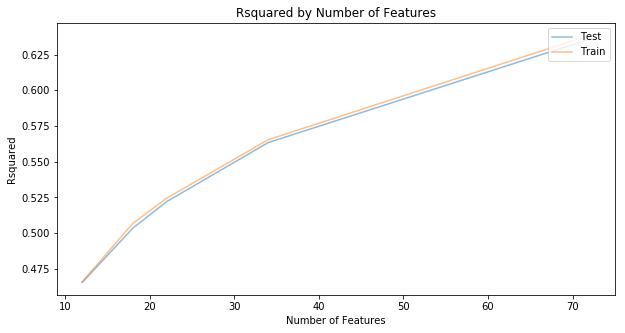

In [113]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25]

#Run this cell to pass your X and y to the model for testing
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [114]:
r2_scores_train

[0.46591379353734574,
 0.50681911836119187,
 0.52442016425999372,
 0.56536528635182992,
 0.63844924608200004,
 0.63844924608200004,
 0.63844924608200004,
 0.63844924608200004]

In [116]:
# Udacity code:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
49,Country_United States,68306.536649,68306.536649
45,Country_Switzerland,64526.182797,64526.182797
23,Country_Israel,59561.885794,59561.885794
12,Country_Denmark,55017.940497,55017.940497
31,Country_Norway,52209.018372,52209.018372
1,Country_Australia,48136.168394,48136.168394
22,Country_Ireland,45950.302048,45950.302048
7,Country_Canada,40525.070115,40525.070115
29,Country_New Zealand,38629.102552,38629.102552
16,Country_Germany,37929.536750,37929.536750


# Conclusion

With 75 features we have reached 0.638 of R2. We see that the both curves are still parallel, no point of separation appears which means that there is still some margin of adding more features. On the other hand, if we use only top 15 countries causing that the number of features drop to 40 then R2 drops to 0.60. I also played with the salary MAX limit and it turns out that it is important to cut off the otliers and limit the salary to 170.000 USD gaving us the best ratio between the number of features and R2. 